In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

### Загрузка данных

In [3]:
X_train = pd.read_csv('C:/Users/1/Data/Dota2_mlcourse/train_features.csv')
Y_train = pd.read_csv('C:/Users/1/Data/Dota2_mlcourse/train_targets.csv')
X_test = pd.read_csv('C:/Users/1/Data/Dota2_mlcourse/test_features.csv')

In [4]:
X_train.drop('match_id_hash', axis = 1, inplace = True)
X_train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,2,124,126,0.000000,0,0,0,0,0.000000,0,0,0,0,14,0,1,0,0,304,0,130,700,700,242.93773,1,70,156,0.000000,0,0,1,0,0.000000,0,0,0,0,59,0,0,0,1,389,4,506,399,700,326.93780,2,170,86,0.000000,0,0,0,0,0.000000,0,0,0,0,77,0,0,0,0,402,10,344,422,800,314.93780,2,120,100,0.000000,0,0,0,0,0.000000,0,0,0,0,12,0,0,1,13,982,12,780,650,720,386.93787,3,82,170,0.000000,0,0,1,0,1.00,0,0,0,0,21,0,0,0,6,788,9,706,640,640,422.93790,3,174,90,0.000000,0,0,2,0,0.00,0,0,0,0,60,0,0,0,1,531,0,307,720,720,242.93773,2,180,84,0.299948,0,0,2,0,0.00,0,0,0,0,84,1,0,0,0,796,0,421,760,760,326.93780,2,90,150,0.000000,0,0,2,1,1.0,0,0,1,0,34,0,0,0,0,851,11,870,593,680,566.93805,3,128,128,0.000000,0,0,0,0,0.00,0,0,0,0
1,658,4,0,3,10,15,7,2,0,7,5257,52,3937,1160,1160,566.93805,8,76,78,0.000000,0,0,0,0,0.437500,0,0,0,0,96,3,1,2,3,3394,19,3897,1352,1380,386.93

In [5]:
Y_train.head()

,match_id_hash,game_time,radiant_win,duration,time_remaining,next_roshan_team
0,a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
1,b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
2,6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
3,46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
4,b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


В качестве вектора ответов оставим только столбец "radiant_win" - его и требуется предсказывать в данной задаче. А также реобразуем значения из булевых в целочисленные

In [6]:
Y_train = Y_train['radiant_win'].astype(int)
Y_train

0        0
1        1
2        1
3        1
4        0
        ..
39670    0
39671    1
39672    0
39673    1
39674    1
Name: radiant_win, Length: 39675, dtype: int32

Далее я использую для решения задачи два подхода: градиентный бустинг и логистическую регрессиию. Модель, показывающая лучшие результаты на кросс-валидации, предскажет исходы игр на тестовых данных.

### 1. Градиентный бустинг

Для проверки обоих моделей создаем генератор разбиений по 5 блокам.

In [7]:
kf = KFold(n_splits = 5, shuffle = True)

Проверим как изменяется качество работы градиентного бустинга с изменением количества деревьев.

In [8]:
grid = {'n_estimators': [20, 40, 60, 80, 100]}

model = GradientBoostingClassifier(learning_rate = 0.1, 
                                   max_depth = 3)

gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                    

In [9]:
GB_score = gs.cv_results_['mean_test_score']
GB_time = gs.cv_results_['mean_fit_time']

In [10]:
# функция для вывода результатов подбора параметров
def results(grid, parameter, score, time):
    for i in range(len(grid)):
        print(parameter, grid[i])
        print('Среднее качество: ', score[i])
        print('Среднее время обучения: ', time[i])

In [11]:
results(grid['n_estimators'], 'Количество деревьев: ',  GB_score, GB_time)

Количество деревьев:  20
Среднее качество:  0.7478198340915727
Среднее время обучения:  22.298798656463624
Количество деревьев:  40
Среднее качество:  0.7677756679147907
Среднее время обучения:  43.53140916824341
Количество деревьев:  60
Среднее качество:  0.7768325511637297
Среднее время обучения:  64.6405927181244
Количество деревьев:  80
Среднее качество:  0.7824103050865017
Среднее время обучения:  86.51424469947816
Количество деревьев:  100
Среднее качество:  0.7861094024547284
Среднее время обучения:  117.49375991821289


In [12]:
# визуализация качества и затраченного на обучение времени
def Visualisation(score, time, grid, parameter, limit = 0.05):
    fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                   ncols=2, 
                                   figsize=(12, 6))
    
    ax1.plot(grid, score, 'g', linewidth=2)
    ax1.grid()
    ax1.legend(['score'])
    ax1.set_xlabel(parameter)
    ax1.set_ylabel('AUC-ROC')
    ax1.set_ylim([min(score) - limit, max(score) + limit])
    
    ax2.plot(grid, time, 'r', linewidth=2)
    ax2.grid()
    ax2.set_xlabel(parameter)
    ax2.set_ylabel('seconds')
    ax2.legend(['time'])
    
    plt.show() 

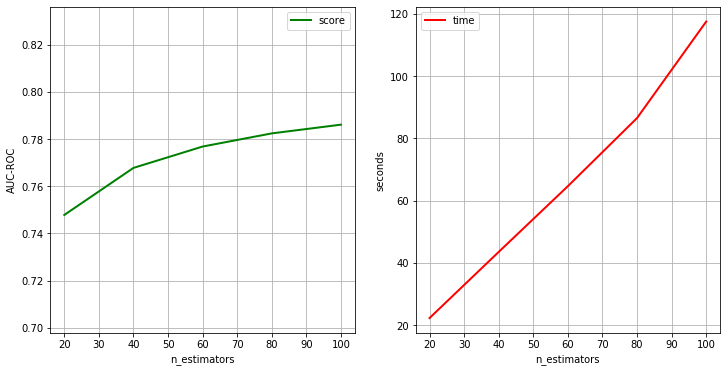

In [13]:
Visualisation(GB_score, GB_time, grid['n_estimators'], 'n_estimators')

Градиентный бустинг из 100 решающих деревьев достиг качества 0.786. Дальнейшее увеличение количества деревьев не сильно улучшает качество классификации.

### 2. Логистическая регрессия

Для использования линейных моделей машинного обучения важно, чтобы признаки объектов были числовыми. Категориальные признаки снижают качество обучения. Удалим их из матрицы объекты-признаки.

In [14]:
categorical_features = ['game_mode', 
                       'lobby_type', 
                       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 
                       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id', 
                       'r1_firstblood_claimed', 'r2_firstblood_claimed', 'r3_firstblood_claimed', 'r4_firstblood_claimed', 'r5_firstblood_claimed', 
                       'd1_firstblood_claimed', 'd2_firstblood_claimed', 'd3_firstblood_claimed', 'd4_firstblood_claimed', 'd5_firstblood_claimed']

X_train_drop = X_train.drop(categorical_features, axis = 1)

Кроме того, важен и масштаб используемых данных. Отмаштабируем признаки.

In [15]:
scaler = StandardScaler()
X_train_drop_transform = scaler.fit_transform(X_train_drop)
X_train_drop_transform = pd.DataFrame(X_train_drop_transform, columns = X_train_drop.columns)

Ранее я отказался от использования категориальных признаков, к которым в том числе относятся и идентификаторы героев, участвовавших в игре. Однако выбранные герои имеют существенное значение для исхода игры - некоторые из них выигрывают чаще, чем другие. Нельзя просто забыть о них.
Для того, чтобы вернуть эти признаки в обучающую выборку, нужно преобразовать их в числовые. Но для начала надо разобраться, сколько всего существует различных идентификаторов.

In [16]:
heroes_columns = ['d1_hero_id', 
                  'd2_hero_id', 
                  'd3_hero_id', 
                  'd4_hero_id', 
                  'd5_hero_id', 
                  'r1_hero_id', 
                  'r2_hero_id', 
                  'r3_hero_id', 
                  'r4_hero_id', 
                  'r5_hero_id']
heroes = X_train[heroes_columns].stack()
unique_values = heroes.unique()
print('Максимальный id: ', unique_values.max())
print('Уникальных id: ', len(unique_values))

Максимальный id:  120
Уникальных id:  115


Получается фактически в игре используются не все идентификаторы. Среди них есть пропуски.

In [17]:
absent_id = []
for i in range(max(unique_values)):
    if (i + 1) not in unique_values:
        absent_id.append(i + 1)
absent_id = np.array(absent_id)
print('Пропущенные id: ', absent_id)

Пропущенные id:  [ 24 115 116 117 118]


Это знание пригодится в дальнейшем, чтобы избавиться от неинформативных признаков.

Одним из подходов для кодирования категориальных признаков является "мешок слов". Сформируем новые признаки, количество которых равно количеству героев, участвовавших в играх. При этом i-й признак равен нулю, если i-й герой не участвовал в конкретном матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire.

In [18]:
X_pick = np.zeros((X_train.shape[0], max(unique_values)))
for i in X_train.index:
    for player in range(5):
        X_pick[i, X_train.loc[i, 'r%d_hero_id' % (player + 1)] - 1] = 1
        X_pick[i, X_train.loc[i, 'd%d_hero_id' % (player + 1)] - 1] = -1

X_pick = pd.DataFrame(X_pick)

Сейчас дата-фрейм имеет столбцы, в которых все значения равны нулю, т.е. герои не участвовали в игре ни разу. Удалим эти столбцы.

In [19]:
X_pick.drop((absent_id - 1), axis = 1, inplace = True)

Объединим отмасштабированные признаки X_train_drop_transform и новые признаки X_pick

In [20]:
X_train_pick = pd.merge(X_train_drop_transform, X_pick, on = X_train_drop_transform.index)
X_train_pick.drop('key_0', axis = 1, inplace = True)
X_train_pick.head()

,game_time,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,...,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,118,119
0,-1.291823,-0.851023,0.273937,-0.845241,-0.995592,-0.893764,-0.766668,-1.022015,-0.753259,-1.036819,-0.859424,-1.150949,-0.909483,-1.369148,-0.150401,0.099524,-0.574276,-0.28337,-0.342075,-0.774483,-1.568074,-0.438388,-0.159039,-0.48499,-0.322141,-0.853792,-0.994633,-0.898766,-0.395514,-1.052488,-0.788433,-1.045118,-0.455736,-0.958173,-1.157218,-1.371206,0.076123,0.245323,-0.583246,-0.279039,-0.33897,-0.997208,-1.580693,-0.437745,-0.15616,-0.489712,-0.3282,-0.852397,-0.686366,-0.898172,-0.770122,-1.062669,-0.843261,-1.093068,-0.357741,-0.990414,-1.185713,-1.519205,-1.500526,1.294203,-0.581614,-0.262309,-0.336133,-0.769645,-1.579969,-0.441039,-0.159748,-0.487478,-0.319889,-0.851130,-0.989514,-0.902939,-0.645515,-1.045738,-0.786224,-1.039625,-0.800541,-0.989796,-0.971413,-1.369392,1.408841,-1.157470,-0.580814,-0.27314,-0.337139,-1.000166,-1.585315,-0.440407,-0.155167,-0.491694,-0.323725,-0.848010,-0.993723,-0.894352,-0.757671,-1.049430,-0.715022,-1.062002,-0.765165,-0.827268,-1.001187,-1.368768,-0.025936,-0.670675,-0.573390,-0.277882,-0.337609,-1.007529,-1.566756,-0.435686,-0.159605,-0.490041,-0.324161,-0.839627,-1.002605,-0.698320,0.774760,-0.947721,-0.691012,-1.002846,-0.438443,-0.950419,-0.816589,-1.220369,-1.457867,...,-0.190919,-0.572130,-0.293984,-0.356055,-1.008776,-1.554715,-0.409309,-0.143248,-0.488654,-0.321294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.636190,-0.542953,0.199121,1.034339,-0.386445,-0.893764,0.086590,-0.297611,-0.168365,-0.581975,0.316532,-0.253869,-0.378016,-0.486244,-1.314054,-1.441513,-0.574276,-0.28337,-0.342075,-1.006199,0.067288,-0.4383

Выполним кросс-валидацию логистической регрессии с подбором параметра регуляризации С (в ходе экспериментов установил, что оптимальное значение лежит в интервале [0.1, 2])

In [21]:
grid = {'C': np.linspace(0.1, 2, 20)}

model = LogisticRegression(penalty = 'l2', 
                           max_iter = 1000)

gs = GridSearchCV(model, 
                  grid, 
                  scoring = 'roc_auc', 
                  cv = kf)

gs.fit(X_train_pick, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [22]:
LR_score = gs.cv_results_['mean_test_score']
LR_time = gs.cv_results_['mean_fit_time']
results(grid['C'], 'Значение параметра С: ', LR_score, LR_time)

Значение параметра С:  0.1
Среднее качество:  0.833248181951421
Среднее время обучения:  5.325590705871582
Значение параметра С:  0.2
Среднее качество:  0.8333320766869372
Среднее время обучения:  5.49560022354126
Значение параметра С:  0.3
Среднее качество:  0.8333388101626273
Среднее время обучения:  5.479809665679932
Значение параметра С:  0.4
Среднее качество:  0.8333356114014432
Среднее время обучения:  5.833019590377807
Значение параметра С:  0.5
Среднее качество:  0.8333280939720906
Среднее время обучения:  5.878601026535034
Значение параметра С:  0.6
Среднее качество:  0.8333273204542705
Среднее время обучения:  6.009200143814087
Значение параметра С:  0.7
Среднее качество:  0.8333269322320191
Среднее время обучения:  6.222201108932495
Значение параметра С:  0.7999999999999999
Среднее качество:  0.8333197114201724
Среднее время обучения:  5.923419618606568
Значение параметра С:  0.8999999999999999
Среднее качество:  0.8333185915259982
Среднее время обучения:  5.87798957824707
З

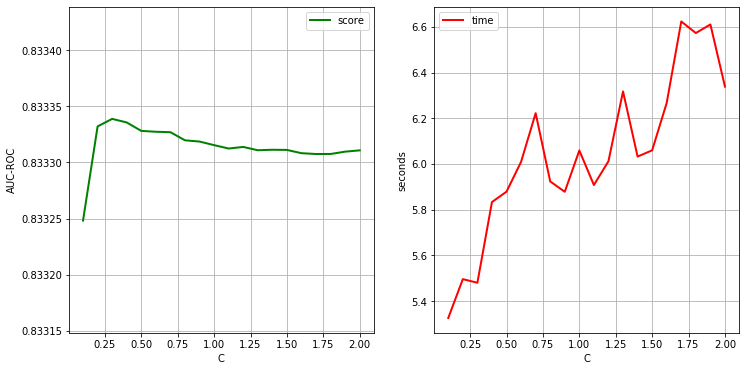

In [23]:
Visualisation(LR_score, LR_time, grid['C'], 'C', limit = 0.0001)

In [24]:
print('Лучший результат: ', gs.best_score_)
print('Результат достигнут при С = ', gs.best_params_['C'])
best_C = gs.best_params_['C']

Лучший результат:  0.8333388101626273
Результат достигнут при С =  0.3


Качество предсказания логистической регрессии заметно лучше, чем у градиентного бустинга. Плюс скорость настройки алгоритма на порядок быстрее.

### Обработка тестовых данных

In [25]:
X_test.drop('match_id_hash', axis = 1, inplace = True)

In [26]:
X_test.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,23,4,0,0,0,79,0,0,0,0,115,0,0,620,620,350.93784,1,86,158,0.000000,0,0,0,0,0.000000,0,0,1,0,47,0,0,0,0,115,0,0,645,660,290.93777,1,172,94,0.0,0,0,1,0,0.000000,0,0,0,0,46,0,0,0,0,115,0,0,620,620,350.93784,1,96,78,0.000000,0,0,0,0,0.000000,0,0,0,0,19,0,0,0,0,115,0,0,800,800,278.93777,1,122,122,0.000000,0,0,1,0,0.000000,0,0,0,0,62,0,0,0,0,115,0,0,500,580,326.93780,1,78,152,0.000000,0,0,0,0,0.000000,0,0,0,0,104,0,0,0,0,115,0,0,692,720,314.93780,1,174,114,0.00000,0,0,1,0,0.000000,0,0,0,0,120,0,0,0,0,115,0,0,520,520,266.93774,1,126,126,0.000000,0,0,0,0,0.000000,0,0,0,0,14,0,0,0,0,115,0,0,700,700,242.93773,1,180,112,0.000000,0,0,0,0,0.000000,0,0,0,0,91,0,0,0,0,115,0,0,253,540,350.93784,1,92,174,0.000000,0,0,0,0,0.000000,0,0,0,0,67,0,0,0,0,115,0,0,610,620,278.93777,1,94,172,0.000000,0,0,1,0,0.000000,0,0,0,0
1,1044,22,7,12,6,23,3,5,7,1,5864,27,5629,1440,1440,542.93800,10,160,154,21.028316,0,0,1,1,0.322581,2,0,2,0,12,9,0,10,9,8271,57,9205,1159,1240,818.93830,

Проверим, отсутствуют ли в X_test те же самые id героев, что и в X_train

In [27]:
sorted(X_test[heroes_columns].stack().unique()) == sorted(unique_values)

True

Как и раньше удалим в тестовых данных категориальные признаки, отмасштабируем и сделаем "мешок слов" по героям

In [28]:
X_test_drop = X_test.drop(categorical_features, axis = 1)
X_test_drop_transform = scaler.transform(X_test_drop)
X_test_drop_transform = pd.DataFrame(X_test_drop_transform, columns = X_test_drop.columns)

In [29]:
X_pick = np.zeros((X_test.shape[0], max(unique_values)))
for i in X_test.index:
    for player in range(5):
        X_pick[i, X_test.loc[i, 'r%d_hero_id' % (player + 1)] - 1] = 1
        X_pick[i, X_test.loc[i, 'd%d_hero_id' % (player + 1)] - 1] = -1

In [30]:
X_pick = pd.DataFrame(X_pick)
X_pick.drop((absent_id - 1), axis = 1, inplace = True)
X_test_pick = pd.merge(X_test_drop_transform, X_pick, on = X_test_drop_transform.index)
X_test_pick.drop('key_0', axis = 1, inplace = True)

In [31]:
X_test_pick.head()

,game_time,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,...,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,118,119
0,-1.463878,-1.005058,-0.549034,-0.845241,-0.995592,-0.893764,-0.766668,-1.087786,-0.844243,-1.108039,-0.475259,-1.118911,-0.909483,-1.516298,-1.023141,1.360373,-0.574276,-0.283370,-0.342075,-1.006199,-1.568074,-0.438388,-0.159039,-0.082194,-0.322141,-0.853792,-0.994633,-0.898766,-0.766457,-1.097174,-0.842137,-1.109582,-0.442485,-1.055213,-1.067805,-1.519283,1.465567,-0.873983,-0.583246,-0.279039,-0.338970,-0.764278,-1.580693,-0.437745,-0.15616,-0.489712,-0.328200,-0.852397,-0.988831,-0.898172,-0.770122,-1.092028,-0.843261,-1.110542,-0.476360,-1.120169,-0.920222,-1.519205,-0.743961,-1.443298,-0.581614,-0.262309,-0.336133,-1.004703,-1.579969,-0.441039,-0.159748,-0.487478,-0.319889,-0.851130,-0.989514,-0.902939,-0.767095,-1.088129,-0.838851,-1.107315,-0.212700,-0.829858,-1.088598,-1.516722,0.017643,0.097854,-0.580814,-0.27314,-0.337139,-0.765052,-1.585315,-0.440407,-0.155167,-0.491694,-0.323725,-0.848010,-0.993723,-0.894352,-0.757671,-1.094310,-0.848803,-1.108334,-0.649762,-1.182422,-0.971589,-1.516639,-1.251144,1.146595,-0.573390,-0.277882,-0.337609,-1.007529,-1.566756,-0.435686,-0.159605,-0.490041,-0.324161,-0.839627,-1.002605,-0.887041,-0.769822,-1.079842,-0.846193,-1.106147,-0.377632,-0.950419,-0.990841,-1.512775,1.235085,...,1.348388,-0.572130,-0.293984,-0.356055,-0.793405,-1.554715,-0.409309,-0.143248,-0.488654,-0.321294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,-0.133059,0.843363,-0.100141,-0.039707,0.527275,0.445876,-0.644774,-0.204332,-0.493306,-0.355889,0.727090,0.194672,-0.437068,-0.191943,1.129618,1.220278,0.451049,-0.283370,-0.342075,-0.774483,-0.362277,2.15

### Обучение модели и предсказание

Обучаем модель с наилучшим параметром регуляризации C

In [32]:
model = LogisticRegression(penalty = 'l2', 
                           C = best_C, 
                           max_iter = 1000)

model.fit(X_train_pick, Y_train)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

В задаче используется метрика AUC-ROC. Это метрика качества для алгоритма, выдающего оценки принадлежности первому классу. Получим эти оценки.

In [33]:
radiant_win_prob = model.predict_proba(X_test_pick)[:, 1]

Формируем файл с ответами

In [34]:
match_id_hash = pd.read_csv('C:/Users/1/Data/Dota2_mlcourse/test_features.csv')['match_id_hash']
submission = pd.DataFrame({'match_id_hash': match_id_hash, 'radiant_win_prob': radiant_win_prob})
submission.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.203113
1,70e5ba30f367cea48793b9003fab9d38,0.967345
2,4d9ef74d3a2025d79e9423105fd73d41,0.956938
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.773308
4,bec17f099b01d67edc82dfb5ce735a43,0.172638


In [35]:
submission.to_csv('submission.csv', index = False)